# Predicting Whether Clients Will Subscribe To A Term Deposit Based On Their Information. 
---

<br> Authors: Godsgift Braimah, Devon Vorster, Chikire Aku-Ibe, & Fu Hung Kwong <br>

In [1]:
import pandas as pd
import numpy as np
import altair_ally as aly
import altair as alt
from deepchecks.tabular.checks import (   
    OutlierSampleDetection,                                                
    IsSingleValue,             
    StringMismatch,            
    ClassImbalance,            
    FeatureLabelCorrelation,   
    FeatureFeatureCorrelation 
)
from deepchecks.tabular import Dataset
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.stats import loguniform, randint, uniform
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandera.pandas as pa
aly.alt.data_transformers.enable('vegafusion')


/Users/braimah/miniforge3/envs/breast-cancer-predictor/lib/python3.11/site-packages/deepchecks/core/serialization/dataframe/html.py:16: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



DataTransformerRegistry.enable('vegafusion')

# Summary:
---
We built a classification model using both the Logistic Regression and Support Vector Classifier (SVC) which can use the information related to the client and the marketing contact to predict whether a client will subscribe to a term deposit.

Our final classifier, the Logistic Regression model, performed well on an unseen test data set, achieving a Test Score (Accuracy) of **0.90375** (compared to **0.90125** for SVC). The Train Score was 0.905625, indicating a good fit without significant overfitting. Although the simple accuracy score does not detail the balance of True Positives versus False Negatives, an accuracy exceeding **90%** suggests the model is highly effective.

Given our goal is to increase the subscription rate, the model's primary goal is to minimize the False Negative rate, avoiding the error of predicting a client will not subscribe when they would have. The current performance suggests that using this model for initial client prioritization could significantly improve resource allocation, making the model valuable for immediate business implementation. However, further analysis of precision and recall would be necessary to optimize its practical utility.

# Introduction:
---
Direct marketing campaigns, particularly those relying on phone calls, are a significant investment for banking institutions. The success of these campaigns is measured by the client subscription rate to a product like a term deposit. Another dataset shows that the subscription rate of term deposit in a Portuguese banking is only around 11.70% [Ngu Hui En 2024](https://medium.com/@nguhe/predictive-analysis-of-client-subscription-rates-in-the-portuguese-banking-sector-using-sas-40fb04a9dcd3), optimizing the targeting strategy is crucial to maximize return on investment and minimize operational costs.

Here we ask if a machine learning algorithm can be used to predict whether a client will subscribe to a term deposit based on information related to the client, such as type of job, education level; and also the marketing contact, e.g. number of contacts during the campaign, number of days since last contact. Answering this question is important because term deposit campaigns often require multiple contacts to the same client, making the process labor-intensive and expensive. Thus, if a machine learning algorithm can accurately and effectively predict client subscription, this could allow the bank to prioritize clients who are most likely to convert, leading to more efficient resource allocation and a higher overall subscription rate, improving the campaign results.

# Methods:
---

## Data: 
The data we used was obtained the UCI Machine Learning Repository which can be found [here](https://doi.org/10.24432/C5K306), specifically the Bank Marketing dataset of a Portuguese bank institution . The dataset contains various features about bank customers and whether they subscribed to a term deposit, an investment product offered by the bank (variable y). Each row in the dataset contains details of customers which was used to predict if they would subscribe to the term deposit or not. The original dataset contains 45211 records with 16 features and one target (17 columns). For the purpose of this analysis, we sampled 4,000 records from the original dataset to speed up the EDA and model training process.


## Analysis: 
We started this analysis by perfoming an exploratory data analysis (EDA) to understand the nature of the variables and their relationships. We observed some missing values in the dataset. We also observed that the target variable (y) was imbalanced with a higher proportion of customers not subscribing to the term deposit. 

Furthermore, distribution plots for variables previous, pday, campaign, duration, balance were highly right-skewed. This implies that most customers had low values for these varaibles and a few customers had high values. In addition, the correlation plots in Figure 3 showed that "previous" and "pday" had the highest positive correlation.

We decided to use both Logistic Regression and Support Vector Classifier (SVC) models for this analysis.The [sklearn](https://scikit-learn.org/stable/) package was greatly used in these processes. We performed hyperparameter tuning using Python RandomizedSearchCV to find the best parameters for each model. We mapped the values of the target y, using 'yes': 1, 'no': 0. The data was split using 80% for the training set and 20% for the test set. In the preprocessing, we dropped 'day_of_week' and 'pdays' because we considered them not relevant for analysis. The 'poutcome' variable was also dropped since it had a high number of missing values. Categorical variables were one-hot encoded, ordinal data were handled using ordinal encoding, numerical variables were scaled using StandardScaler and missing values for the selected features were imputed using SimpleImputer with the "most frequent" strategy.

The models were evaluated based on their accuracy on the test set. 


### Loading The Data

In [2]:
## Download Data 

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
  
# metadata 
print(bank_marketing.metadata) 
  
# variable information 
print(bank_marketing.variables) 

# create complete dataset
bank_marketing_data =X; bank_marketing_data['y'] = y
#bank_marketing_data.to_csv('data/bank_marketing.csv')

# take a sample from teh data set
bank_marketing_sample = bank_marketing_data.sample(4000, random_state=522)
#bank_marketing_sample.to_csv('data/bank_marketing_small.csv')

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

### Data Validation

During our data valuation, we checked the following:
- Correct data file format
- Correct column names
- No empty observations
- Missingness not beyond expected threshold
- Correct data types in each column
- No duplicate observations
- No outlier or anomalous values
- Correct category levels (i.e., no string mismatches or single values)
- Target/response variable follows expected distribution
- No anomalous correlations between target/response variable and features/explanatory variables
- No anomalous correlations between features/explanatory variables

After our checks, we observed that our data had the correct data file format, correct column names, no empty observations, no missingness beyond expected threshold, correct data types in each column, and no duplicate observations. 

In [3]:
# split data
train_df, test_df = train_test_split(
    bank_marketing_sample, test_size=0.2, 
    stratify=bank_marketing_sample['y'],
    random_state=522)

In [4]:
# validate data code adapted from Tiffany A. Timbers, Joel Ostblom & Melissa Lee 2023/11/09's code
#Check for correct data file format:
def assert_csv_format(file_path):
    assert file_path.endswith(".csv"), "Error: File must be a CSV."
    return True

#Check for correct column names, correct data types in each column, no outlier or anomalous values:
schema = pa.DataFrameSchema(
    {
        "age": pa.Column(int, pa.Check.between(18, 91), nullable=True),
        "job": pa.Column(object, pa.Check.isin(['technician', 'blue-collar', 'admin.', 'entrepreneur',
       'management', 'self-employed', 'retired', 'services', 'unemployed',
       'housemaid', 'student']), nullable=True),
        "marital": pa.Column(object, pa.Check.isin(['married', 'single', 'divorced']), nullable=True),
        "education": pa.Column(object, pa.Check.isin(['tertiary', 'secondary', 'primary']), nullable=True), 
        "default": pa.Column(object, pa.Check.isin(['no', 'yes']), nullable=True),
        "balance": pa.Column(int, pa.Check.between(-10000000, 10000000), nullable=True),
        "housing": pa.Column(object, pa.Check.isin(['yes', 'no']), nullable=True),
        "loan": pa.Column(object, pa.Check.isin(['no', 'yes']), nullable=True),
        "contact": pa.Column(object, pa.Check.isin(['cellular', 'telephone']), nullable=True),
        "day_of_week": pa.Column(int, pa.Check.between(1, 31), nullable=True),
        "month": pa.Column(object, pa.Check.isin(['feb', 'nov', 'jul', 'may', 'aug', 'jun', 'apr', 'mar', 'jan',
       'oct', 'sep', 'dec']), nullable=True),
        "duration": pa.Column(int, pa.Check.between(0, 4000), nullable=True),
        "campaign": pa.Column(int, pa.Check.between(0, 40), nullable=True),
        "pdays": pa.Column(int, pa.Check.between(-1, 800), nullable=True), 
        "previous": pa.Column(int, pa.Check.between(0, 30), nullable=True),
        "poutcome": pa.Column(object, pa.Check.isin(['failure', 'success', 'other']), nullable=True),
        "y": pa.Column(object, pa.Check.isin(['no', 'yes']), nullable=True),
    },
    #check for no duplicate observations, no empty observations and missingness not beyond expected threshold:
    checks=[
        pa.Check(lambda df: ~df.duplicated().any(), error="Duplicate rows found."),
        pa.Check(lambda df: ~(df.isna().all(axis=1)).any(), error="Empty rows found."),
        pa.Check(lambda df: (df.isna().mean() < 0.10).any(), error="Missing values is above threshold.")
    ]
)
assert_csv_format("data/data_marketing_sample.csv")
schema.validate(bank_marketing_sample, lazy=True)


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
30577,42,technician,married,tertiary,no,1397,yes,no,cellular,6,feb,135,7,-1,0,NaN,no
30048,51,blue-collar,married,secondary,no,362,yes,yes,cellular,4,feb,318,3,-1,0,NaN,no
24147,23,admin.,single,secondary,no,40,no,no,telephone,10,nov,1239,1,-1,0,NaN,no
25584,57,entrepreneur,married,tertiary,no,1828,yes,no,cellular,19,nov,68,1,-1,0,NaN,no
15822,47,management,divorced,tertiary,no,2105,no,yes,cellular,21,jul,363,1,-1,0,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15271,41,management,single,tertiary,no,0,yes,no,cellular,17,jul,509,7,-1,0,NaN,no
22396,31,management,single,tertiary,no,10215,no,no,cellular,22,aug,139,2,-1,0,NaN,no
21330,60,self-employed,married,tertiary,no,3,no,no,cellular,18,aug,80,2,-1,0,NaN,no
36012,43,self-employed,married,tertiary,yes,310,yes,no,cellular,11,may,84,7,-1,0,NaN,no


### EDA 

In [4]:
# split data
train_df, test_df = train_test_split(bank_marketing_sample, test_size=0.2, random_state=522)

In [5]:
(train_df.isnull().sum() / train_df.shape[0]) * 100

age             0.00000
job             0.78125
marital         0.00000
education       3.75000
default         0.00000
balance         0.00000
housing         0.00000
loan            0.00000
contact        29.59375
day_of_week     0.00000
month           0.00000
duration        0.00000
campaign        0.00000
pdays           0.00000
previous        0.00000
poutcome       83.40625
y               0.00000
dtype: float64

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3200 entries, 4731 to 37152
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          3200 non-null   int64 
 1   job          3175 non-null   object
 2   marital      3200 non-null   object
 3   education    3080 non-null   object
 4   default      3200 non-null   object
 5   balance      3200 non-null   int64 
 6   housing      3200 non-null   object
 7   loan         3200 non-null   object
 8   contact      2253 non-null   object
 9   day_of_week  3200 non-null   int64 
 10  month        3200 non-null   object
 11  duration     3200 non-null   int64 
 12  campaign     3200 non-null   int64 
 13  pdays        3200 non-null   int64 
 14  previous     3200 non-null   int64 
 15  poutcome     531 non-null    object
 16  y            3200 non-null   object
dtypes: int64(7), object(10)
memory usage: 450.0+ KB


In [8]:

numeric_plot = aly.dist(train_df, color='y')

numeric_plot.properties(
    title="Figure 1: Univariate distributions of numeric variables in Bank Marketing Dataset"
)

alt.ConcatChart(...)

In [9]:
# univariate distrbutions (counts) for the categorical variables

categorical_plots = aly.dist(
    train_df, dtype='object', color='y')

categorical_plots.properties(
    title="Figure 2: Univariate distributions of category variables in Bank Marketing Dataset"
)


alt.ConcatChart(...)

In [10]:
correlation_plots = aly.corr(bank_marketing_sample)
correlation_plots.properties(
    title="Figure 3: Correlation Plots For Numeric variables in Bank Marketing Dataset"
)


/Users/braimah/miniforge3/envs/breast-cancer-predictor/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning:

'selection_multi' is deprecated.  Use 'selection_point'

/Users/braimah/miniforge3/envs/breast-cancer-predictor/lib/python3.11/site-packages/altair/vegalite/v5/api.py:394: AltairDeprecationWarning:

The value of 'empty' should be True or False.



alt.ConcatChart(...)

### Data Preprocessing, Model Building and Evaluation

In [11]:
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
16093,27,blue-collar,married,primary,no,237,yes,no,cellular,22,jul,283,6,-1,0,NaN,no
14526,29,entrepreneur,married,secondary,no,926,yes,no,cellular,15,jul,169,2,-1,0,NaN,no
19761,51,blue-collar,married,primary,no,507,yes,no,cellular,8,aug,85,2,-1,0,NaN,no
20123,34,management,divorced,tertiary,no,4231,yes,no,cellular,11,aug,382,2,-1,0,NaN,no
17548,59,unemployed,married,primary,no,46,no,no,telephone,29,jul,44,2,-1,0,NaN,no


In [12]:
# preprocessing

# map the target variable to numeric
train_df['y'] = train_df['y'].map({'yes': 1, 'no': 0})
test_df['y'] = test_df['y'].map({'yes': 1, 'no': 0})


# feature engineering on 'pdays' column into categorical determining if client was contacted before or not
train_df['pdays_contacted'] = train_df['pdays'].apply(lambda x: 'never' if x == -1 else 'contacted')
test_df['pdays_contacted'] = test_df['pdays'].apply(lambda x: 'never' if x == -1 else 'contacted')


# Drop columns that are not needed from EDA: poutcome has 83% missing values.
drop_cols = ['day_of_week', 'pdays', 'poutcome']
train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)

# split data
X_train = train_df.drop(columns='y')
X_test = test_df.drop(columns='y')
y_train = train_df['y']
y_test = test_df['y']

In [13]:
# Rename target column for Deepchecks
train_df.rename(columns={'y': 'target'}, inplace=True)
test_df.rename(columns={'y': 'target'}, inplace=True)

# create Deepchecks Dataset
X_train_ds = Dataset(train_df, label="target", cat_features=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'pdays_contacted'])

# Outlier Detection
check_outliers = OutlierSampleDetection()
check_outliers.add_condition_outlier_ratio_less_or_equal(0.05)
result_outliers = check_outliers.run(X_train_ds)

# Single Value Check
check_single_val = IsSingleValue()
result_single_val = check_single_val.run(X_train_ds)

# String Mismatch Check
check_string_mismatch = StringMismatch()
result_string_mismatch = check_string_mismatch.run(X_train_ds)

# Class Imbalance Check
check_imbalance = ClassImbalance()
check_imbalance.add_condition_class_ratio_less_than(0.99)
result_imbalance = check_imbalance.run(X_train_ds)

result_checks = {
              'Outliers': result_outliers,
              'Single Value': result_single_val,
              'String Mismatch': result_string_mismatch,
              'Class Imbalance': result_imbalance
       }

for name, result in result_checks.items():
       if not result.passed_conditions():
              raise ValueError(f"Check '{name}' failed!!")
       else:
              print(f"Check '{name}' passed.")
              

Check 'Outliers' passed.
Check 'Single Value' passed.
Check 'String Mismatch' passed.
Check 'Class Imbalance' passed.


In [14]:
# create Deepchecks Dataset for Test Data
X_test_ds = Dataset(test_df, label="target", cat_features=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'pdays_contacted'])

# Outlier Detection
check_outliers = OutlierSampleDetection()
check_outliers.add_condition_outlier_ratio_less_or_equal(0.05)
result_outliers = check_outliers.run(X_test_ds)

# Single Value Check
check_single_val = IsSingleValue()
result_single_val = check_single_val.run(X_test_ds)

# String Mismatch Check
check_string_mismatch = StringMismatch()
result_string_mismatch = check_string_mismatch.run(X_test_ds)

# Class Imbalance Check
check_imbalance = ClassImbalance()
check_imbalance.add_condition_class_ratio_less_than(0.99)
result_imbalance = check_imbalance.run(X_test_ds)

result_checks_test = {
            'Outliers': result_outliers,
            'Single Value': result_single_val,
            'String Mismatch': result_string_mismatch,
            'Class Imbalance': result_imbalance
       }

for name, result in result_checks_test.items():
       if not result.passed_conditions():
           raise ValueError(f"Check '{name}' failed!!")
       else:
           print(f"Check '{name}' passed.")
              

Check 'Outliers' passed.
Check 'Single Value' passed.
Check 'String Mismatch' passed.
Check 'Class Imbalance' passed.


In [15]:
# separating columns by type of transformation required

# One-hot encoding
categorical_cols = ['job', 'marital', 'default', 'housing', 'loan', 'contact','month', 'pdays_contacted']
# Ordinal encoding
ordinal_cols = ['education']
# Standard scaling
numerical_cols = ['age', 'balance', 'duration', 'campaign', 'previous']

We decided to train both a Logistic Regression and Support Vector Classifier (SVC) to determine which was more efficient in predicting if a customer would subscribed to the banks offering of term investments. We performed hyperparameter tuning using RandomizedSearchCV to find the best parameters for each model. The models were evaluated based on their accuracy on the test set.

In [15]:
# defining the preprocessor

data_preprocessor = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy='most_frequent'), 
                      OneHotEncoder(handle_unknown='ignore')), 
                      categorical_cols
    ), (
        make_pipeline(SimpleImputer(strategy='most_frequent'), 
                      OrdinalEncoder(categories=[['unknown', 'primary', 'secondary', 'tertiary']], dtype=object)), 
                      ordinal_cols
    ), (
        StandardScaler(), numerical_cols
        )
    )

In [17]:
# Code adapted from from Tiffany A. Timbers, Joel Ostblom & Melissa Lee 2023/11/09: Breast Cancer Predictor Report
data_preprocessor.fit(X_train)
scaled_X_train = data_preprocessor.transform(X_train)

col_names = data_preprocessor.named_transformers_['pipeline-1'].get_feature_names_out().tolist() + ordinal_cols + numerical_cols
scaled_X_train_df = pd.DataFrame(scaled_X_train, columns=col_names)


correlation_matrix = scaled_X_train_df[numerical_cols].corr()
correlation_long = correlation_matrix.reset_index().melt(id_vars='index')
correlation_long.columns = ['Feature 1', 'Feature 2', 'Correlation']

alt.Chart(correlation_long).mark_rect().encode(
    x='Feature 1:O',
    y='Feature 2:O',
    color=alt.Color('Correlation:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=['Feature 1', 'Feature 2', 'Correlation']
).properties(
    width=400,
    height=400,
    title="Correlation Heatmap"
)

alt.Chart(...)

In [18]:
# Code adapted from from Tiffany A. Timbers, Joel Ostblom & Melissa Lee 2023/11/09: Breast Cancer Predictor Report
# Data validation checks: feature-target and feature-feature correlations

# Check feature-label correlations
check_feat_lab_corr = FeatureLabelCorrelation().add_condition_feature_pps_less_than(0.9)
check_feat_lab_corr_result = check_feat_lab_corr.run(dataset=X_train_ds)

# Check feature-feature correlations
check_feat_feat_corr = FeatureFeatureCorrelation().add_condition_max_number_of_pairs_above_threshold(threshold = 0.92, n_pairs = 0)
check_feat_feat_corr_result = check_feat_feat_corr.run(dataset=X_train_ds)

if not check_feat_lab_corr_result.passed_conditions():
    raise ValueError("Feature-Label correlation exceeds the maximum acceptable threshold.")

if not check_feat_feat_corr_result.passed_conditions():
    raise ValueError("Feature-feature correlation exceeds the maximum acceptable threshold.")

In [19]:
# Logistic Regression cross-validation with RandomizedSearchCV 
lr_pipe = make_pipeline(data_preprocessor, LogisticRegression(random_state=42, max_iter=1000))
param_dist1 = {"logisticregression__C": loguniform(1e-4, 1e3)} 
random_lr = RandomizedSearchCV(lr_pipe, param_distributions=param_dist1,
                                n_iter=100, n_jobs=-1, return_train_score=True, random_state=522)

In [20]:
# Fit model
random_lr.fit(X_train, y_train)
print(f'Train Score: {random_lr.score(X_train, y_train)}')
print(f'Test Score: {random_lr.score(X_test, y_test)}')

/Users/braimah/miniforge3/envs/breast-cancer-predictor/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/braimah/miniforge3/envs/breast-cancer-predictor/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Users/braimah/miniforge3/envs/breast-cancer-predictor/lib/python3.11/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is

Train Score: 0.9103125
Test Score: 0.88875


In [21]:
# SVC cross-validation with RandomizedSearchCV 
svc_pipe = make_pipeline(data_preprocessor, SVC(random_state=42))
param_dist = { "svc__C": loguniform(1e-2, 1e3), "svc__gamma": loguniform(1e-2, 1e3)}
random_svc = RandomizedSearchCV(svc_pipe, param_distributions=param_dist,
                                n_iter=100, n_jobs=-1, return_train_score=True, random_state=522)


In [22]:
# Fit model
#The random_svc.fit() takes a while to run.
random_svc.fit(X_train, y_train)
print(f'Train Score: {random_svc.score(X_train, y_train)}')
print(f'Test Score: {random_svc.score(X_test, y_test)}')

Train Score: 0.9490625
Test Score: 0.9075


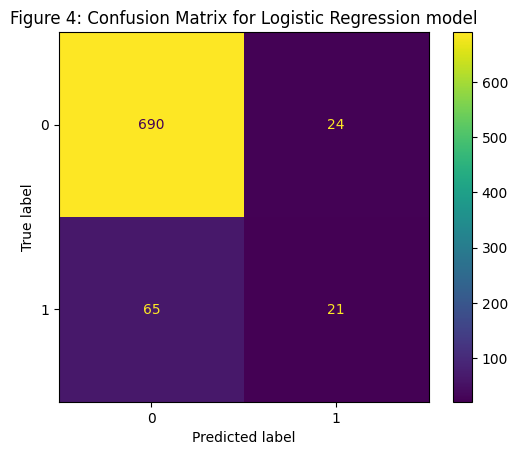

In [23]:
#Confusion Matrix for Logistic Regression model
ConfusionMatrixDisplay.from_estimator(
    random_lr,
    X_test,
    y_test,
    values_format="d",
);
plt.title("Figure 4: Confusion Matrix for Logistic Regression model")
plt.show()

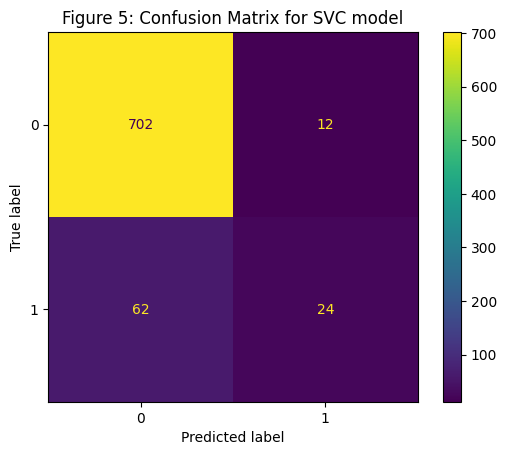

In [24]:
#Confusion Matrix for SVC model

y = ConfusionMatrixDisplay.from_estimator(
    random_svc,
    X_test,
    y_test,
    values_format="d",
);
plt.title("Figure 5: Confusion Matrix for SVC model")
plt.show()


# Results & Discussion
---

Our SVC classification model performed well on the testing data, with testing scores of 0.9075 compared to our Logistic Regression with an accuracy of 0.88875. Further comparison shows that the testing scores are similar to the training scores of 0.9490625 for SVC and 0.9103125 for Logistic Regression. 

Considering the imbalance in our target class, accuracy alone is not sufficient for determining the suitability of our model. Therefore, exploring metrics from the confusion matrix and classification report is recommended as a next step.

A second area for further analysis is determining which specific features are most important for predicting whether a client will subscribe to a term deposit. Identifying these key features will enable the bank to better tailor its actions to increase subscription rates. In light of this, the Logistic Regression model is a better choice, as it provides more interpretable results. However, due to interactions between features and preprocessing steps such as regularization, the coefficients of the Logistic Regression model can become difficult to interpret. Nevertheless, if properly examined, the coefficient estimates can help identify the important characteristics the bank should focus on to increase its rate of subscriptions to term deposits.

# References:
---
<br> Ngu, H. E. (2024). Predictive analysis of client subscription rates in the Portuguese banking sector using SAS. Medium. https://medium.com/@nguhe/predictive-analysis-of-client-subscription-rates-in-the-portuguese-banking-sector-using-sas-40fb04a9dcd3 <br>
<br>Timbers, T. (n.d.). breast_cancer_predictor (Version 0.0.1) [Computer software]. GitHub. https://github.com/ttimbers/breast_cancer_predictor/tree/0.0.1<br>
<br>Moro, S., Rita, P., & Cortez, P. (2014). Bank Marketing [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306. <br>
<br>Scikit-learn. (n.d.). scikit-learn: Machine learning in Python. Retrieved November 21, 2025, from https://scikit-learn.org/stable/<br>
<br>uci-ml-repo (2025). ucimlrepo: Python package for dataset imports from the UCI Machine Learning Repository [Computer software]. GitHub. https://github.com/uci-ml-repo/ucimlrepo<br>
<br>Timbers, T. (n.d.). breast-cancer-predictor [Computer software]. GitHub. Retrieved November 16, 2025, from https://github.com/ttimbers/breast-cancer-predictor<br>